In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv('[RAW] Mid-TermProject_16-09-27_Data_5percent.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258000 entries, 0 to 257999
Columns: 137 entries, DeviceName to udp.time_relative
dtypes: bool(6), float64(64), int64(5), object(62)
memory usage: 259.3+ MB
None


In [2]:
df.head()

,DeviceName,Frame_length,Frame_protocols_in,arp.dst_hw_mac,arp.dst_proto_ipv4,arp.hw_size,arp.hw_type,arp.opcode,arp.proto_size,arp.proto_type,...,udp.checksum,udp.checksum_status,udp.dstport,udp.length,udp.port,udp.srcport,udp.stream,udp.stream_pnum,udp.time_delta,udp.time_relative
0,Dropcam,156,eth:ethertype:ip:tcp:tls,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TPLink Router Bridge LAN (Gateway),66,eth:ethertype:ip:tcp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Dropcam,284,eth:ethertype:ip:tcp:tls,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Dropcam,156,eth:ethertype:ip:tcp:tls,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TPLink Router Bridge LAN (Gateway),90,eth:ethertype:ip:udp:ntp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0xb440,2.0,4967.0,56.0,123.0,123.0,0.0,1.0,0.0,0.0


In [3]:
print("Original shape:", df.shape)
# df = df.drop(['eth.addr', 'eth.addr_oui', 'eth.addr_oui_resolved', 'eth.addr_resolved',
#               'eth.dst', 'eth.dst_oui_resolved', 'eth.dst_resolved', 'eth.src', 'eth.src_ig',
#               'eth.src_lg', 'eth.src_oui', 'eth.src_oui_resolved', 'eth.src_resolved', 'ip.addr',
#               'ip.dst', 'ip.dst_host', 'ip.host', 'ip.src', 'ip.src_host', 'arp.dst_hw_mac',
#               'arp.dst_proto_ipv4', 'arp.src_hw_mac', 'arp.src_proto_ipv4'], axis=1)
print("Shape after removing unreliable data:", df.shape)

Original shape: (258000, 137)
Shape after removing unreliable data: (258000, 137)


In [4]:
# Drop duplicate rows
df = df.drop_duplicates(keep="first")
print("Shape after removing duplicate rows:", df.shape)

Shape after removing duplicate rows: (217517, 137)


In [5]:
print("Empty values in the dataset:")
print(df.isna().sum().sort_values())
print("\nTotal:", df.isna().sum().sum())

Empty values in the dataset:
DeviceName                   0
eth.stream                   0
eth.src_resolved             0
eth.src_oui_resolved         0
eth.src_oui                  0
                         ...  
arp.hw_type             217442
arp.opcode              217442
arp.proto_size          217442
arp.src_proto_ipv4      217442
arp.proto_type          217442
Length: 137, dtype: int64

Total: 10570511


In [6]:
# Impute missing values
from sklearn.impute import SimpleImputer

# For numerical columns with only 1 type of value (and N/A), replace N/A with zeroes
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
for i in df[numerical_cols]:
    if (len(df[i].unique()) < 2):
        df[numerical_cols] = df[numerical_cols].fillna(0)

# For other numerical columns, simply replace empty values with the mean
num_imputer = SimpleImputer(strategy='mean')
df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])

# For string columns with only 1 type of value (and N/A), replace N/A with the string "N/A"
object_cols = df.select_dtypes(include=['object']).columns
for a in df[object_cols]:
    if (len(df[a].unique()) < 2):
        df[a] = df[a].fillna("N/A")
# For boolean columns with only 1 type of value (and N/A), replace N/A with the inverse of that boolean
bool_cols = df.select_dtypes(include=['bool']).columns
for b in df[bool_cols]:
    if (len(df[b].unique()) < 2):
        df[b] = df[b].fillna(not bool(df[b].mode()[0]))
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns

# For other categorical columns, simply replace empty values with the mode
cat_imputer = SimpleImputer(strategy="most_frequent")
df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])

print("Empty values after imputing:")
print(df.isna().sum())
print("\nTotal:", df.isna().sum().sum())

Empty values after imputing:
DeviceName            0
Frame_length          0
Frame_protocols_in    0
arp.dst_hw_mac        0
arp.dst_proto_ipv4    0
                     ..
udp.srcport           0
udp.stream            0
udp.stream_pnum       0
udp.time_delta        0
udp.time_relative     0
Length: 137, dtype: int64

Total: 0


In [7]:
# Feature encoding for categorical columns
from sklearn.preprocessing import OneHotEncoder

categorical_features = categorical_cols.drop(['DeviceName'])

print("Dropping categorical features with too many different values:")
for i in df[categorical_features]:
    if (len(df[i].unique()) > 50):
        print("\t", i, ": " , len(df[i].unique()), sep="")
        categorical_features = categorical_features.drop([str(i)])
df[categorical_features].head()

Dropping categorical features with too many different values:
	Frame_protocols_in: 64
	icmp.checksum: 9384
	ip.addr: 234
	ip.checksum: 63301
	ip.dst: 251
	ip.dst_host: 251
	ip.host: 234
	ip.id: 62293
	ip.src: 234
	ip.src_host: 234
	tcp._ws_expert: 144
	tcp._ws_expert_message: 144
	tcp.checksum: 60297
	tcp.options: 141096
	tcp.options_timestamp: 141018
	udp.checksum: 5645


,arp.dst_hw_mac,arp.dst_proto_ipv4,arp.proto_type,arp.src_hw_mac,arp.src_proto_ipv4,eth.addr,eth.addr_oui_resolved,eth.addr_resolved,eth.dst,eth.dst_ig,...,tcp.flags_fin,tcp.flags_push,tcp.flags_res,tcp.flags_reset,tcp.flags_str,tcp.flags_syn,tcp.flags_urg,tls.record,tls.record_version,udp.
0,00:00:00:00:00:00,192.168.1.1,0x0800,14:cc:20:51:33:ea,192.168.1.1,14:cc:20:51:33:ea,"Tp-Link Technologies Co.,Ltd.",14:cc:20:51:33:ea,14:cc:20:51:33:ea,False,...,False,True,False,False,·······AP···,False,False,TLSv1 Record Layer: Application Data Protocol:...,0x0301,Timestamps
1,00:00:00:00:00:00,192.168.1.1,0x0800,14:cc:20:51:33:ea,192.168.1.1,30:8c:fb:2f:e4:b2,Dropcam,30:8c:fb:2f:e4:b2,30:8c:fb:2f:e4:b2,False,...,False,False,False,False,·······A····,False,False,TLSv1 Record Layer: Application Data Protocol:...,0x0301,Timestamps
2,00:00:00:00:00:00,192.168.1.1,0x0800,14:cc:20:51:33:ea,192.168.1.1,14:cc:20:51:33:ea,"Tp-Link Technologies Co.,Ltd.",14:cc:20:51:33:ea,14:cc:20:51:33:ea,False,...,False,True,False,False,·······AP···,False,False,TLSv1 Record Layer: Application Data Protocol:...,0x0301,Timestamps
3,00:00:00:00:00:00,192.168.1.1,0x0800,14:cc:20:51:33:ea,192.168.1.1,14:cc:20:51:33:ea,"Tp-Link Technologies Co.,Ltd.",14:cc:20:51:33:ea,14:cc:20:51:33:ea,False,...,False,True,False,False,·······AP···,False,False,TLSv1 Record Layer: Application Data Protocol:...,0x0301,Timestamps
4,00:00:00:00:00:00,192.168.1.1,0x0800,14:cc:20:51:33:ea,192.168.1.1,d0:52:a8:00:67:5e,Physical Graph Corporation,d0:52:a8:00:67:5e,d0:52:a8:00:67:5e,False,...,False,False,False,False,·······A····,False,False,TLSv1 Record Layer: Application Data Protocol:...,0x0301,Timestamps


In [8]:
print("Initializing OneHotEncoder...")
encoder = OneHotEncoder(sparse_output=False)
# Fit and transform the categorical features
print("Fitting data...")
encoder.fit(df[categorical_features])
print("Transforming data...")
encoded = encoder.transform(df[categorical_features])
print("Converting into DataFrame...")
df_encoded = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_features))

df_encoded.head()

Initializing OneHotEncoder...
Fitting data...
Transforming data...
Converting into DataFrame...


,arp.dst_hw_mac_00:00:00:00:00:00,arp.dst_hw_mac_00:16:6c:ab:6b:88,arp.dst_hw_mac_00:24:e4:11:18:a8,arp.dst_hw_mac_00:24:e4:1b:6f:96,arp.dst_hw_mac_14:cc:20:51:33:ea,arp.dst_hw_mac_18:b4:30:25:be:e4,arp.dst_hw_mac_44:65:0d:56:cc:d3,arp.dst_hw_mac_50:c7:bf:00:56:39,arp.dst_hw_mac_70:ee:50:03:b8:ac,arp.dst_hw_mac_70:ee:50:18:34:43,...,tls.record_TLSv1.2 Record Layer: Handshake Protocol: Client Key Exchange,tls.record_TLSv1.2 Record Layer: Handshake Protocol: Encrypted Handshake Message,tls.record_TLSv1.2 Record Layer: Handshake Protocol: Multiple Handshake Messages,tls.record_TLSv1.2 Record Layer: Handshake Protocol: New Session Ticket,tls.record_TLSv1.2 Record Layer: Handshake Protocol: Server Hello,tls.record_TLSv1.2 Record Layer: Handshake Protocol: Server Hello Done,tls.record_TLSv1.2 Record Layer: Handshake Protocol: Server Key Exchange,tls.record_version_0x0301,tls.record_version_0x0303,udp._Timestamps
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [9]:
df = df.reset_index(drop=True)
df_encoded = df_encoded.reset_index(drop=True)

print("Concatenating encoded columns with numerical...")
X = pd.concat([df.drop(columns=categorical_cols), df_encoded], axis=1)
print("Features (x):")
X.head()

Concatenating encoded columns with numerical...
Features (x):


,Frame_length,arp.hw_size,arp.hw_type,arp.opcode,arp.proto_size,eth.addr_oui,eth.dst_oui,eth.src_oui,eth.stream,icmp.checksum_status,...,tls.record_TLSv1.2 Record Layer: Handshake Protocol: Client Key Exchange,tls.record_TLSv1.2 Record Layer: Handshake Protocol: Encrypted Handshake Message,tls.record_TLSv1.2 Record Layer: Handshake Protocol: Multiple Handshake Messages,tls.record_TLSv1.2 Record Layer: Handshake Protocol: New Session Ticket,tls.record_TLSv1.2 Record Layer: Handshake Protocol: Server Hello,tls.record_TLSv1.2 Record Layer: Handshake Protocol: Server Hello Done,tls.record_TLSv1.2 Record Layer: Handshake Protocol: Server Key Exchange,tls.record_version_0x0301,tls.record_version_0x0303,udp._Timestamps
0,156.0,6.0,1.0,1.413333,4.0,1362976.0,1362976.0,3181819.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,66.0,6.0,1.0,1.413333,4.0,3181819.0,3181819.0,1362976.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,284.0,6.0,1.0,1.413333,4.0,1362976.0,1362976.0,3181819.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,156.0,6.0,1.0,1.413333,4.0,1362976.0,1362976.0,3181819.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,90.0,6.0,1.0,1.413333,4.0,13652648.0,13652648.0,1362976.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [10]:
y = df['DeviceName']
print('Label (y):', y.name)
print(f"Classes ({len(y.unique())}):\n", y.unique())

Label (y): DeviceName
Classes (18):
 ['Dropcam' 'TPLink Router Bridge LAN (Gateway)' 'Netatmo Welcome '
 'Amazon Echo' 'Smart Things' 'Withings Smart Baby Monitor '
 'Samsung SmartCam ' 'TP-Link Day Night Cloud camera '
 'Belkin Wemo switch ' 'Triby Speaker' 'HP Printer'
 'Belkin wemo motion sensor ' 'PIX-STAR Photo-frame '
 'TP-Link Smart plug ' 'Netatmo weather station ' 'Samsung Galaxy Tab'
 'NEST Protect smoke alarm ' 'Withings Smart scale ']


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
import numpy as np


print("Train/test split...", end=" ")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print("Done")

Train/test split... Done


Preparing plot...
Iteration 0
	Training classifier...
	Calculating results...
	Loading for plotting...
Iteration 1
	Training classifier...
	Calculating results...
	Loading for plotting...
Iteration 2
	Training classifier...
	Calculating results...
	Loading for plotting...
Iteration 3
	Training classifier...
	Calculating results...
	Loading for plotting...
Iteration 4
	Training classifier...
	Calculating results...
	Loading for plotting...
Iteration 5
	Training classifier...
	Calculating results...
	Loading for plotting...
Iteration 6
	Training classifier...
	Calculating results...
	Loading for plotting...
Iteration 7
	Training classifier...
	Calculating results...
	Loading for plotting...
Iteration 8
	Training classifier...
	Calculating results...
	Loading for plotting...
Plotting...


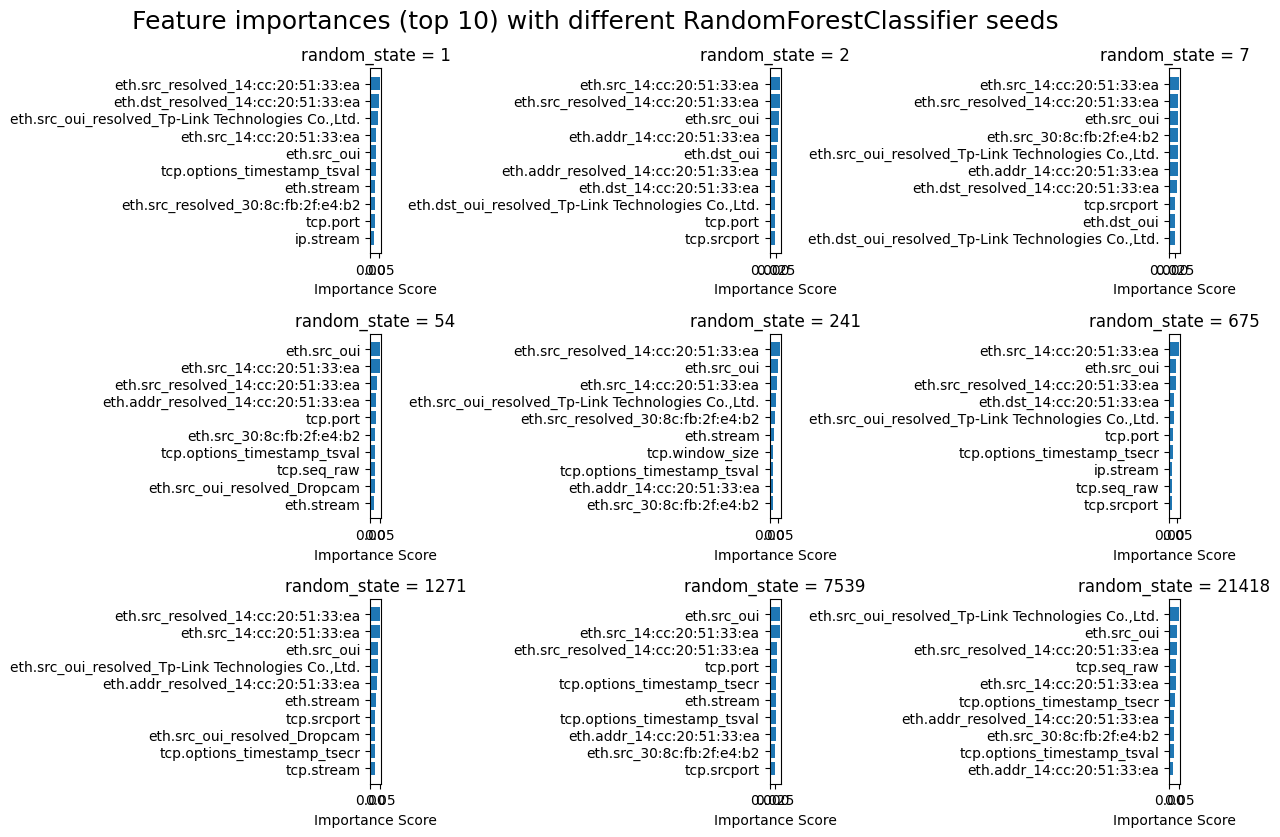

In [12]:
seeds = [1, 2, 7, 54, 241, 675, 1271, 7539, 21418] # Seeds for reproducibility
top_n = 10 # Use 10 most important features
all_importances = np.zeros((len(seeds), len(X_train.columns))) # Store importances with every seed to compute mean later

print("Preparing plot...")

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 8.5))
fig.suptitle('Feature importances (top 10) with different RandomForestClassifier seeds', fontsize=18)

for i, seed in enumerate(seeds):

    print("Iteration", i)
    
    # Train RandomForest with current seed
    rf = RandomForestClassifier(
        bootstrap=True, max_samples=0.5,
        n_estimators=100, max_depth=10,
        n_jobs=-1, random_state=seed)
    print("\tTraining classifier...")
    rf.fit(X_train, y_train)

    print("\tCalculating results...")
    
    # Get and sort feature importances
    importances = rf.feature_importances_
    all_importances[i] = importances
    sorted_idx = np.argsort(importances)[::-1][:top_n]
    sorted_importances = importances[sorted_idx]
    sorted_feature_names = [X_train.columns[j] for j in sorted_idx]
    
    # Select subplot (3x3 grid)
    ax = axes[i//3, i%3]
    
    # Plot horizontal bar chart
    print("\tLoading for plotting...")
    ax.barh(range(len(sorted_feature_names)), sorted_importances)
    ax.set_yticks(range(len(sorted_feature_names)))
    ax.set_yticklabels(sorted_feature_names)
    ax.invert_yaxis() # Most important at top
    ax.set_xlabel('Importance Score')
    ax.set_title(f'random_state = {seed}')

print("Plotting...")
plt.tight_layout()
plt.show()

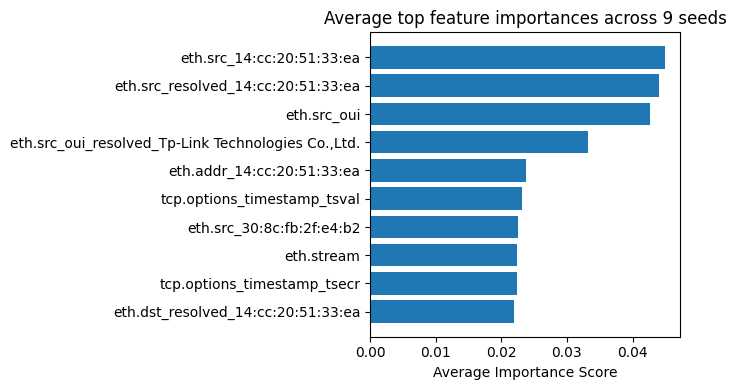

In [13]:
# Compute mean importances across seeds
mean_importances = np.mean(all_importances, axis=0)

# Sort features by mean importance (descending)
sorted_idx = np.argsort(mean_importances)[::-1][:top_n]
sorted_importances = mean_importances[sorted_idx]
sorted_feature_names = [X.columns[j] for j in sorted_idx]

# Plot the averaged importances
plt.figure(figsize=(7, 4))
plt.barh(range(len(sorted_feature_names)), sorted_importances)
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.gca().invert_yaxis()
plt.xlabel('Average Importance Score')
plt.title('Average top feature importances across 9 seeds')
plt.tight_layout()
plt.show()

Training classifier...
Calculating results...
Plotting...


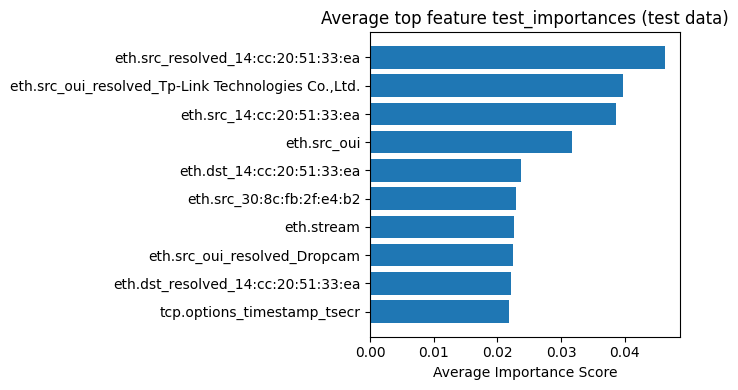

In [14]:
# Comparing results against test data

rf = RandomForestClassifier(
    n_estimators=200,
    n_jobs=-1, random_state=1)
print("Training classifier...")
rf.fit(X_test, y_test)

print("Calculating results...")
test_importances = rf.feature_importances_
test_sorted_idx = np.argsort(test_importances)[::-1][:top_n]
test_sorted_importances = test_importances[test_sorted_idx]
test_sorted_feature_names = [X_test.columns[j] for j in test_sorted_idx]

print("Plotting...")
plt.figure(figsize=(7, 4))
plt.barh(range(len(test_sorted_feature_names)), test_sorted_importances)
plt.yticks(range(len(test_sorted_feature_names)), test_sorted_feature_names)
plt.gca().invert_yaxis()
plt.xlabel('Average Importance Score')
plt.title('Average top feature test_importances (test data)')
plt.tight_layout()
plt.show()

In [15]:
# Feature selection
X = X[sorted_feature_names]
print(X.shape)
X.head()

(217517, 10)


,eth.src_14:cc:20:51:33:ea,eth.src_resolved_14:cc:20:51:33:ea,eth.src_oui,"eth.src_oui_resolved_Tp-Link Technologies Co.,Ltd.",eth.addr_14:cc:20:51:33:ea,tcp.options_timestamp_tsval,eth.src_30:8c:fb:2f:e4:b2,eth.stream,tcp.options_timestamp_tsecr,eth.dst_resolved_14:cc:20:51:33:ea
0,0.0,0.0,3181819.0,0.0,1.0,2.318916e+07,1.0,0.0,4.049397e+09,1.0
1,1.0,1.0,1362976.0,1.0,0.0,4.049398e+09,0.0,0.0,2.318916e+07,0.0
2,0.0,0.0,3181819.0,0.0,1.0,2.318921e+07,1.0,0.0,4.049398e+09,1.0
3,0.0,0.0,3181819.0,0.0,1.0,2.318937e+07,1.0,0.0,4.049398e+09,1.0
4,1.0,1.0,1362976.0,1.0,0.0,1.550935e+09,0.0,1.0,1.568876e+09,0.0


In [18]:
# Saving as a processed CSV file
df_out = pd.concat([y, X], axis=1)
filename = 'PROCESSED.csv'
df_out.to_csv(filename, index=False)
print("Wrote", df_out.shape[0], "rows and", df_out.shape[1], "columns to", filename)

Wrote 217517 rows and 11 columns to PROCESSED.csv
